# Feature Extraction

Flow aggregation by a time window

Generated features:
* NumSrcPorts
* NumDestAddr
* NumDestPorts
* NumFlows
* NumBytesSum
* NumBytesMean
* NumBytesVar
* NumPacketsSum
* NumPacketsMean
* NumPacketsVar

## Imports

In [140]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
import glob
import time

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

import warnings

import matplotlib.pyplot as plt
import itertools

import pickle

warnings.filterwarnings("ignore")

## Functions

In [141]:
features = ["NumSrcPorts", "NumDestAddr", "NumDestPorts", "NumFlows",
                   "NumBytesSum", "NumBytesMean", "NumBytesVar",
                   "NumPacketsSum", "NumPacketsMean", "NumPacketsVar"]

def calc_confusion_matrix(y_t, y_p, encoding):
    """Calculate Confusion matrix and count hits and misses"""
    
    confusion_matrix = np.zeros((13,13)).astype(int)
    hit = 0
    miss = 0
    
    for i in range(len(y_t)):
        if encoding == 'ohe':
            pred = y_p[i].argmax()
            truth = y_t[i].argmax()
        else:
            pred = y_p[i]-1
            truth = y_t[i]-1
            
        if pred == truth:
            confusion_matrix[pred, pred] += 1
            hit += 1
        else:
            confusion_matrix[truth, pred] += 1
            miss += 1
    return confusion_matrix, hit, miss

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    http://scikit-learn.org/stable/auto_examples/
    model_selection/plot_confusion_matrix.html
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def load_pickle_data(scenario = -1):
    if scenario == -1:
        p_filename = "botnet_cache/botnet_feat_list.p"
    else:
        p_filename = "botnet_cache/botnet_scenario_features_"+str(scenario)+".p"
        
    return pickle.load(open(p_filename, "rb" ) )

## Load Data

In [142]:
feat_list = load_pickle_data()
gen_feat_df = pd.concat(feat_list)
gen_feat_df.reset_index(drop=True, inplace=True)
gen_feat_s_df = pd.concat([gen_feat_df, pd.get_dummies(gen_feat_df['Scenario'])],axis=1)
gen_feat_s_df[features[:4]] = gen_feat_s_df[features[:4]].astype(int)
gen_feat_s_df[features[4:]] = gen_feat_s_df[features[4:]].astype(float)
gen_feat_s_df.head()

,NumSrcPorts,NumDestAddr,NumDestPorts,NumFlows,NumBytesSum,NumBytesMean,NumBytesVar,NumPacketsSum,NumPacketsMean,NumPacketsVar,...,4,5,6,7,8,9,10,11,12,13
0,2,2,2,3,780.0,260.000000,6.816867e+04,11.0,3.666667,5.555556,...,0,0,0,0,0,0,0,0,0,0
1,10,7,6,18,15072.0,837.333333,1.075430e+06,510.0,28.333333,1910.444444,...,0,0,0,0,0,0,0,0,0,0
2,22,18,6,24,20881.0,870.041667,3.699151e+06,659.0,27.458333,6182.414931,...,0,0,0,0,0,0,0,0,0,0
3,13,13,4,13,2771.0,213.153846,1.712798e+04,47.0,3.615385,3.159763,...,0,0,0,0,0,0,0,0,0,0
4,16,15,4,16,7261.0,453.812500,6.050515e+05,183.0,11.437500,865.246094,...,0,0,0,0,0,0,0,0,0,0


# Machine Learning Models

We Split train and test data 70% - 30%

The reason that we have two different methods is: sklearn learning algorithms accept different kinds of inputs.

We want to feed the algorithms with one-hot encoded outputs where each scenario is represented by a different feature and is eaither one or zero. But unfortunatelly, Logistic Regression and SVM classifiers only accepts Integer Valued Encoding which creates a bias between classes.

## Generate test and train sets

In [143]:
# Integer Value Encoding for LR and SVM
def generate_train_test_ive():
    # Generate test and train sets
    X = gen_feat_s_df[features].values
    y = gen_feat_s_df['Scenario'].values
    y = y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

    # Feature Counts
    print("Feature Counts\n")
    print("num\ttrain\ttest\ttotal")
    print("-" * 30)
    for i in range(1, 14):
        print("{0}\t{1}\t{2}\t{3}".format(i, np.count_nonzero(y_train==i), np.count_nonzero(y_test==i), np.count_nonzero(y==i)))
    print("-" * 30)
    print("total:\t{0}\t{1}\t{2}".format(len(y_train), len(y_test), len(y)))

    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    print()
    
    return X_train, X_test, y_train, y_test

In [144]:
# One-Hot Encoding for KNN and RF
def generate_train_test_ohe():
    # Generate test and train sets
    X = gen_feat_s_df[features].values
    y = gen_feat_s_df[list(range(1,14))].values
    y = y.astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)


    # Scale Data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)


    # Feature Counts
    print("Feature Counts\n")
    print("num\ttrain\ttest\ttotal")
    print("-" * 30)
    for i in range(1, 14):
        print("{0}\t{1}\t{2}\t{3}".format(i, np.count_nonzero(y_train[:,i-1]), np.count_nonzero(y_test[:,i-1]), np.count_nonzero(y[:,i-1])))
    print("-" * 30)
    print("total:\t{0}\t{1}\t{2}".format(len(y_train), len(y_test), len(y)))
    print()
    
    return X_train, X_test, y_train, y_test

## Evaluation Functions - Prints

In [145]:
def print_results(y_test, y_pred, encoding):
    print("\nAccuracy:")
    print(metrics.accuracy_score(y_test, y_pred))
    
    print("\nClassification report:")
    print(metrics.classification_report(y_test, y_pred, target_names=["1","2","3","4","5","6","7","8","9","10","11","12","13"]))
    
    
    confusion_matrix, hit, miss = calc_confusion_matrix(y_test, y_pred,encoding)    
    plt.figure(figsize=(8,6))
    plot_confusion_matrix(confusion_matrix,
                          classes=["1","2","3","4","5","6","7","8","9","10","11","12","13"],
                                   normalize=True,
                                   title='Normalized confusion matrix (Train)')
    plt.show()

## Models - (Cross Validation)

In [146]:
def logistic_regression_cv(C=1e5, cv=5):
    log_regression = LogisticRegression(C=C)

    X_train, X_test, y_train, y_test = generate_train_test_ive()

    scores = cross_val_score(log_regression, X_train, y_train, cv=cv)
    print("CV Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
def svm_classifier_cv(kernel='rbf', C=1e5, cv=5):
    svm_clf = svm.SVC(kernel=kernel, C=C)

    X_train, X_test, y_train, y_test = generate_train_test_ive()

    scores = cross_val_score(svm_clf, X_train, y_train, cv=cv)
    print("CV Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    
def knn_classifier_cv(cv=5):
    cv_scores = []
    k_vals = []
    
    X_train, X_test, y_train, y_test = generate_train_test_ohe()
    for i in range(10):
        k = 2*i+1
        knn = KNeighborsClassifier(n_neighbors=k)
        
        scores = cross_val_score(knn, X_train, y_train, cv=cv)
        print("CV Score (k = %d): %0.2f (+/- %0.2f)" % (k, scores.mean(), scores.std() * 2))
        
        cv_scores.append(scores.mean())
        k_vals.append(k)
        
    # print_results()
    plt.plot(k_vals, cv_scores)
    plt.title("CV Scores vs. k values")
    plt.xlabel("k")
    plt.ylabel("CV Score")
    plt.grid(True)
    plt.show()
    
def random_forest_cv(n_estimators=25, cv=5):
    rand_forest_clf = RandomForestClassifier(n_estimators=n_estimators)

    X_train, X_test, y_train, y_test= generate_train_test_ohe()

    scores = cross_val_score(rand_forest_clf, X_train, y_train, cv=cv)
    print("CV Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [115]:
logistic_regression_cv(C = 1e5, cv = 5)

Feature Counts

num	train	test	total
------------------------------
1	355	176	531
2	262	98	360
3	1188	489	1677
4	93	42	135
5	25	10	35
6	139	60	199
7	2	2	4
8	828	362	1190
9	1858	798	2656
10	345	132	477
11	10	4	14
12	81	44	125
13	1263	547	1810
------------------------------
total:	6449	2764	9213

CV Score: 0.77 (+/- 0.02)


## Models - (Train -Test)

In [147]:
def logistic_regression(C=1e5):
    log_regression = LogisticRegression(C=C)

    X_train, X_test, y_train, y_test = generate_train_test_ive()

    # Train the classifier
    log_regression.fit(X_train, y_train)

    # Predict
    y_pred = log_regression.predict(X_test)

    print()
    print('*'*35)
    print_results(y_test, y_pred, 'ive')
    
def svm_classifier(kernel='rbf', C=1e5):
    svm_clf = svm.SVC(kernel=kernel, C=C)

    X_train, X_test, y_train, y_test = generate_train_test_ive()

    svm_clf.fit(X_train, y_train)

    y_pred = svm_clf.predict(X_test)

    print()
    print('*'*35)
    print_results(y_test, y_pred, 'ive')
    
def knn_classifier(n_neighbors=1):
    X_train, X_test, y_train, y_test = generate_train_test_ohe()
    
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    
    print()
    print('*'*35)
    print_results(y_test, y_pred, 'ohe')
    
def random_forest(n_estimators=25, graph = False):
    rand_forest_clf = RandomForestClassifier(n_estimators=n_estimators)

    X_train, X_test, y_train, y_test= generate_train_test_ohe()

    rand_forest_clf.fit(X_train, y_train)

    y_pred = rand_forest_clf.predict(X_test)

    print()
    print('*'*35)
    print_results(y_test, y_pred, 'ohe')
    
    
    importances = np.round(rand_forest_clf.feature_importances_, 3)
    print(pd.DataFrame(np.array([features, importances]).T, columns=['Features', 'Importance']))


    if graph:
        #https://stats.stackexchange.com/questions/130206/sklearn-tree-export-graphviz-values-do-not-add-up-to-samples
        from sklearn.tree import export_graphviz

        class_names = [str(i) for i in rand_forest_clf.classes_]

        export_graphviz(rand_forest_clf.estimators_[0],
                        feature_names=features,
                        class_names=class_names,
                        filled=True,
                        rounded=True)

        os.system('dot -Tpng tree.dot -o tree.png')

Feature Counts

num	train	test	total
------------------------------
1	355	176	531
2	262	98	360
3	1188	489	1677
4	93	42	135
5	25	10	35
6	139	60	199
7	2	2	4
8	828	362	1190
9	1858	798	2656
10	345	132	477
11	10	4	14
12	81	44	125
13	1263	547	1810
------------------------------
total:	6449	2764	9213


***********************************

Accuracy:
0.8856729377713459

Classification report:
             precision    recall  f1-score   support

          1       0.86      0.69      0.77       176
          2       0.76      0.61      0.68        98
          3       1.00      0.98      0.99       489
          4       0.76      0.45      0.57        42
          5       0.00      0.00      0.00        10
          6       0.78      0.82      0.80        60
          7       0.00      0.00      0.00         2
          8       0.98      0.96      0.97       362
          9       0.94      0.93      0.94       798
         10       0.92      0.88      0.90       132
         11       0.00      0

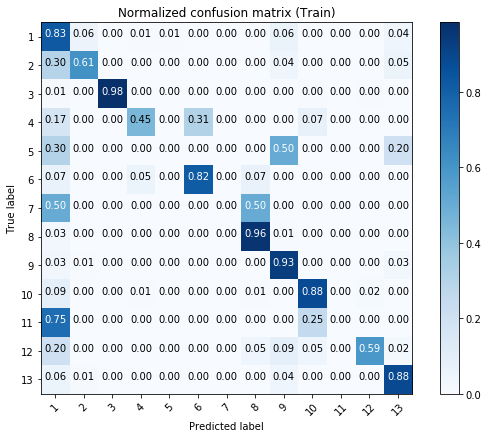

         Features Importance
0     NumSrcPorts      0.167
1     NumDestAddr      0.094
2    NumDestPorts      0.066
3        NumFlows      0.164
4     NumBytesSum      0.116
5    NumBytesMean      0.099
6     NumBytesVar      0.018
7   NumPacketsSum      0.113
8  NumPacketsMean      0.108
9   NumPacketsVar      0.054


In [148]:
random_forest(n_estimators=5)